In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader

In [2]:
x_data = np.linspace(-100, 100, 30000)
y_data = np.sin(x_data) / x_data

In [3]:
dataset = Dataset(torch.tensor(x_data).float(), torch.tensor(y_data).float())
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [4]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(1, 1000, 1)

In [5]:
for i, (x, y) in enumerate(trainloader):
    H = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ x.reshape(1, -1)).T
    Y = y.reshape(1, -1).T
    if i == 0:
        P = torch.linalg.inv(H.T @ H + torch.eye(H.shape[1]))
        W2 = P @ H.T @ Y.reshape(1, -1, 1)
    else:
        P = P - P @ H.T @ torch.linalg.inv(torch.eye(H.shape[0]) + H @ P @ H.T) @ H @ P
        W2 = W2 + P @ H.T @ (Y.reshape(1, -1, 1) - H @ W2)
    model.fc2.weight.data = W2[0].T

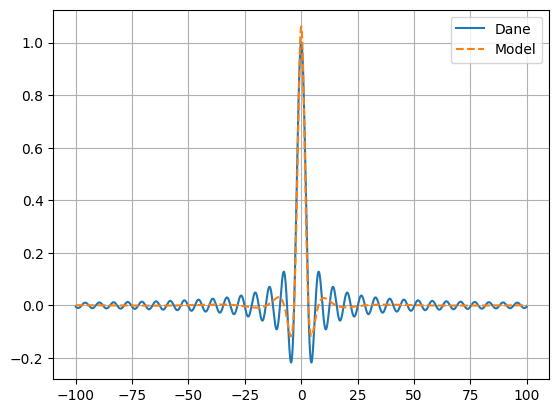

In [6]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).float()).detach().numpy(), '--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()